(c) 2023 Nong Artrith (n.artrith@uu.nl)

----

This notebook is based on the data and approach from references [1,2] and demonstrates the construction of a model for the prediction of transition-state energies from reaction energies as well as models for the prediction of ethanol reforming activities and selectivities.  If work based on this notebook is published, please cite the following references.

[1] N. Artrith, Z. Lin, and J. Chen, *ACS Catal.* **10**, 2020, 9438-9444, https://doi.org/10.1021/acscatal.0c02089

[2] S. R. Denny, Z. Lin, W. N. Porter, N. Artrith, and J. G. Chen, *Appl. Catal. B* **312**, 2022, 121380, https://doi.org/10.1016/j.apcatb.2022.121380

# Catalytic Ethanol Reforming Analyzed with Machine Learning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt
plt.rcParams['font.size'] = '12'

## Data set

We load the data used/produced in reference [1] directly from the associated GitHub repository.

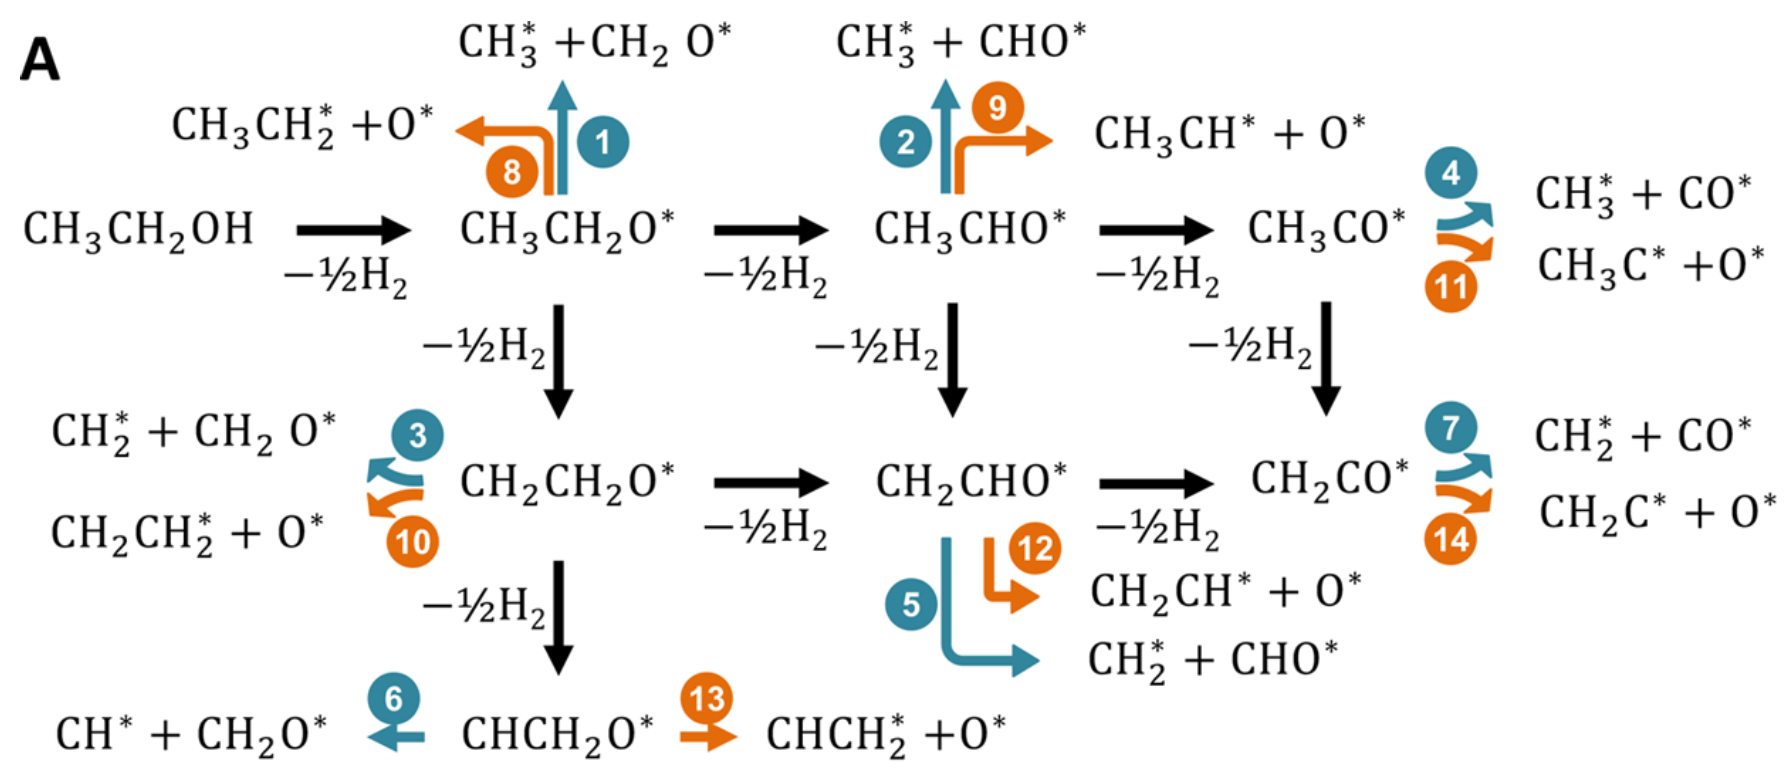

In [ ]:
dft_data_url = 'https://raw.githubusercontent.com/atomisticnet/ml-catalysis/master/ethanol-reforming/database-dft.csv'
df_dft = pd.read_csv(dft_data_url)
df_dft.head()

In [ ]:
features = df_dft[['d_NN(top)',       # nearest-neighbor distance within top layer material
                   'd_NN(2nd)',       # nearest-neighbor distance within 2nd layer material
                   'EN(top)',         # electronegativity of the top layer material
                   'EN(2nd)',         # electronegativity of the 2nd layer material
                   'Facet',           # surface facet
                   'Eads(CH3CH2OH)',  # ethanol adsorption energy
                   'N_H',             # number of hydrogen atoms
                   'Initial',         # relative energy of the initial state
                   'Final']]          # relative energy of the final state

features

In [ ]:
targets = df_dft['E_TS']  # relative energy of the transition-state
# where unknown, E_TS is set to 100
targets.values

Standardization of the features by removing the mean and scaling the variance to 1.  See also: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [ ]:
feature_scaler = StandardScaler().fit(
                    np.array(features.values, dtype=np.float64))

# now select only data points corresponding to the (111) facet
# and including transition-state energies
select = (df_dft['Facet'] == 1) & (df_dft['has_TS'] == 1)
X = feature_scaler.transform(
      np.array(features[select].values, dtype=np.float64))
Y = targets[select].values

## Brønsted–Evans–Polanyi (BEP) Model

The BEP model is based on the assumption that the activation energy $E_a$ is correlated with the reaction energy $E_r$.

In [ ]:
# the activation energy is the difference between the 
# transition-state energy and the energy of the initial state
Ea = df_dft['E_TS'] - df_dft['Initial']
Ea = Ea[select].values

# the reaction energy is the energy difference between 
# the final and initial state
Er = df_dft['Final'] - df_dft['Initial']
Er = Er[select].values

We use numpy to fit a polynomial of degree 1 (i.e., a line) to the activation energy as a function of the reaction energy.

In [ ]:
c0, c1 = np.polyfit(Er, Ea, 1)
Ea_bep = np.poly1d([c0, c1])

To facilitate the comparison of the BEP model with the models constructed below, we want it to return the transition state energy instead of the activation energy.  We also want it to take the same features as input, even though we only need the energies of the initial and final state.  So, a small adjustement is needed.

In [ ]:
def bep_model(X):
    # we only need the final feature (X[:, -1] = "energy of the final state") 
    # and the second to last feature (X[:, -2] = "energy of the initial state")
    Er = X[:, -1] - X[:, -2]
    Ea = Ea_bep(Er)
    # the transition-state energy is the initial-state energy
    # plus the activation energy
    return df_dft['Initial'][select].values + Ea

Y_bep = bep_model(X)

print('BEP RMSE = {:.3f} eV'.format(mean_squared_error(Y, Y_bep, squared=False)))
print('BEP MAE  = {:.3f} eV'.format(mean_absolute_error(Y, Y_bep)))

Above, we evaluated the *root mean squared error* (RMSE) and the *mean absolute error* (MAE) as accuracy metrics.  However, note that we used all of the data points to fit the BEP model.  Better error estimates could have been obtained by dividing the data into training and testing points.  We will do this for the more complex models below, but for the linear BEP model we will not spend this extra effort because the model has a small number of parameters (2) compared to the number of data points.

Still, to see how well the predicted energies correlate with the reference energies, it is helpful to inspect a correlation plot.

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot([0, 6], [0, 6], c='black', lw=0.5)
ax.scatter(Y, Y_bep, marker='x')
ax.set_xlabel('TS Energy Target Value (eV)')
ax.set_ylabel('TS Energy BEP Prediction (eV)')
ax.set_xlim((0, 6))
ax.set_ylim((0, 6))
plt.show()

As seen in the plot, the BEP model exhibits significant scatter.  Now let's find out if more complex models can give better approximations to the transition-state energy.

## Random Forest Regression Model

Random forests have *hyperparameters*, namely the maximal depth and the number of estimators.  The optimal value of these hyperparameters needs to be determined separately, usually by evaluating models on a *validation set*.  Here, we will use the parameters that were found to be optimal in reference [1].

*scikit-learn* offers functions to help with hyperparameter optimization. Please see also https://scikit-learn.org/stable/modules/grid_search.html

In [ ]:
rfr_model = RandomForestRegressor(
              max_depth=9, 
              n_estimators=15, 
              random_state=1234, 
              verbose=False)

To estimate the accuracy of the RFR model, we will perform leave-one-out cross-validation (LOO-CV).  This means, we will fit models on all but one data point and predict the error for the data point that was left out.  Sciki-learn makes this straightforward.

In [ ]:
Y_rfr = []

loo = LeaveOneOut()
for i, (train_index, test_index) in enumerate(loo.split(X)):
    rfr_model.fit(X[train_index], Y[train_index])
    Y_rfr.append(rfr_model.predict(X[test_index]))
 
print('RFR RMSE = {:.3f} eV'.format(mean_squared_error(Y, Y_rfr, squared=False)))
print('RFR MAE  = {:.3f} eV'.format(mean_absolute_error(Y, Y_rfr)))

# fit the model to all data points for later
rfr_model.fit(X, Y);

Plotting the LOO-CV errors.

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot([0, 6], [0, 6], c='black', lw=0.5)
ax.scatter(Y, Y_rfr, marker='x')
ax.set_xlabel('TS Energy Target Value (eV)')
ax.set_ylabel('TS Energy RFR Prediction (eV)')
ax.set_xlim((0, 6))
ax.set_ylim((0, 6))
plt.show()

This looks already significantly better than the BEP model from above.  The points are well distributed along the diagonal.  However, the scatter remains significant, and an RMSE of ~0.4 eV is still larger than we would like

## Gaussian Process Regression Model

Now we will do the same for the GPR model.  Again, we will use the hyperparameters that were found to work well in the original reference.  In this case, the hyperparameters determine the *Kernel* used in the GPR model.  We use a radial basis function (RBF).

In [ ]:
kernel = RBF(length_scale=2.0, length_scale_bounds=(1e-05, 100000.0))
gpr_model = GaussianProcessRegressor(
              kernel=kernel, alpha=0.05, random_state=False)

Once again, we evaluate the model with LOO-CV.

In [ ]:
Y_gpr = []

loo = LeaveOneOut()
for i, (train_index, test_index) in enumerate(loo.split(X)):
    gpr_model.fit(X[train_index], Y[train_index])
    Y_gpr.append(rfr_model.predict(X[test_index]))

print('GPR RMSE = {:.3f} eV'.format(mean_squared_error(Y, Y_gpr, squared=False)))
print('GPR MAE  = {:.3f} eV'.format(mean_absolute_error(Y, Y_gpr)))

# fit the model to all data points for later
gpr_model.fit(X, Y);

The GPR model is quite a bit more accurate than the RFR model.  This is also evident in the correlation plot.

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot([0, 6], [0, 6], c='black', lw=0.5)
ax.scatter(Y, Y_gpr, marker='x')
ax.set_xlabel('TS Energy Target Value (eV)')
ax.set_ylabel('TS Energy GPR Prediction (eV)')
ax.set_xlim((0, 6))
ax.set_ylim((0, 6))
plt.show()

## Ensemble (RFR & GPR) model

We constructed two completely different models based on the same data.  As a third model, we combine both of the models from above into a single *ensemble model*.  This is useful because the difference between both models can be interpreted as an uncertainty metric.  Note that the GPR model provides, in principle, the uncertainty of the Gaussian process, but the GPR uncertainty can depend a lot on the Kernel, and it would be good to have an independent measure as well.

In [ ]:
Y_ensemble = (np.array(Y_rfr) + np.array(Y_gpr))/2.0
print('(RFR+GPR) RMSE = {:.3f} eV'.format(mean_squared_error(Y, Y_ensemble, squared=False)))
print('(RFR+GPR) MAE  = {:.3f} eV'.format(mean_absolute_error(Y, Y_ensemble)))

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot([0, 6], [0, 6], c='black', lw=0.5)
ax.scatter(Y, Y_ensemble, marker='x')
ax.set_xlabel('TS Energy Target Value (eV)')
ax.set_ylabel('TS Energy (RFR+GPR) Prediction (eV)')
ax.set_xlim((0, 6))
ax.set_ylim((0, 6))
plt.show()

## Evaluating the TS Energy for all Reactions

Now that we have a model for the TS energy, we can use it to evaluate the TS energies for those reactions in our database for which we only know the initial and final energies.  Since we only used (111) facet information to construct the model, we will also only predict the TS energies for reactions over that facet.

In [ ]:
# now select only data points corresponding to the (111) facet
# and NOT including transition-state energies
select1 = (df_dft['Facet'] == 1) & (df_dft['has_TS'] == 0)
# initial = df_dft['Initial'][select1].values
X1 = feature_scaler.transform(
      np.array(features[select1].values, dtype=np.float64))

Y1_rfr = rfr_model.predict(X1)
Y1_gpr, uncert_gpr = gpr_model.predict(X1, return_std=True)
Y1_ensemble = (Y1_rfr + Y1_gpr)/2

The GPR model returns an uncertainty that we can inspect to determine how reliable the predicted TS energies are.  However, this uncertainty depends on the kernel, and it might not be an accurate reflection of the expected error.  We therefore also inspect a second uncertainty metric, the difference between the RFR and GPR model predictions.

In [ ]:
uncert_ensemble = np.abs(Y1_rfr - Y1_gpr)/2

Now let's plot the predicted transition-state energies and their uncertainties.

In [ ]:
materials = df_dft['Surface'][select1].values

fig, ax = plt.subplots()
xval = [0]
for m in set(materials):
    idx = np.array([i for i in range(len(X1)) if materials[i] == m])
    x0 = xval[-1] + 1
    xval = [i+x0 for i in range(len(idx))]
    ax.errorbar(xval, Y1_ensemble[idx], yerr=uncert_ensemble[idx], 
                marker='o', markersize=2.0, lw=0, elinewidth=1,
                label=m)
ax.set_xlabel('Reaction')
ax.set_ylabel('TS Energy Prediction (eV)')
ax.set_xlim([0, len(X1)+1])
ax.set_ylim([0, 5])
ax.legend(loc='upper left', bbox_to_anchor=(1.04, 1.03), fontsize=10)
plt.show()

As seen in the above plot, for some of the systems the RFR and GPR models predict very different TS energies, especially for Sc-Pt-Pt(111) and Pt-Sc-Pt(111).  In these cases, the TS-energy trends among the different reactions might still be better, but we should probably not trust the predictions too much.  For the other materials, the two models are in significantly better agreement.

Let's now remove the three systems with high error bars and combine the predicted data with the DFT data into a single data frame.

In [ ]:
df_all = df_dft.copy()
df_all.loc[select1, 'E_TS'] = Y1_ensemble
df_all['Uncertainty'] = 0.0
df_all.loc[select1, 'Uncertainty'] = uncert_ensemble
df_all = df_all[df_all['Surface'] != 'Sc-Pt-Pt(111)']
df_all = df_all[df_all['Surface'] != 'Pt-Sc-Pt(111)']
materials = df_all['Surface'].values
df_all

Here is a final plot of our transition-state energy database, combining DFT calculations and ML predictions.

In [ ]:
fig, ax = plt.subplots()
xval = [0]
for m in set(materials):
    idx = (df_all['Surface'] == m)
    E_TS = df_all[idx]['E_TS'].values
    uncert = df_all[idx]['Uncertainty'].values
    x0 = xval[-1] + 1
    xval = [i+x0 for i in range(len(E_TS))]
    ax.errorbar(xval, E_TS, yerr=uncert, 
                marker='o', markersize=2.0, lw=0, elinewidth=1,
                label=m)
ax.set_xlabel('Reaction')
ax.set_ylabel('TS Energy Prediction (eV)')
ax.set_xlim([0, len(df_all)+1])
ax.set_ylim([0, 5])
ax.legend(loc='upper left', bbox_to_anchor=(1.04, 1.03), fontsize=10)
plt.show()

## Data from Experiment



In [ ]:
exp_data_url = 'https://raw.githubusercontent.com/atomisticnet/ml-catalysis/master/ethanol-reforming/database-experiment.csv'
df_exp = pd.read_csv(exp_data_url)
df_exp

To construct models of the catalytic activity and selectivity, we consider 14 potential C-C and C-O scission reactions in the ethanol reforming reaction network.

Note: for some of the surfaces, the C-O bond scission reactions (10) and (13) could not be modeled with DFT without simultaneous C-C bond scission, so these reactions were excluded from the list of features.

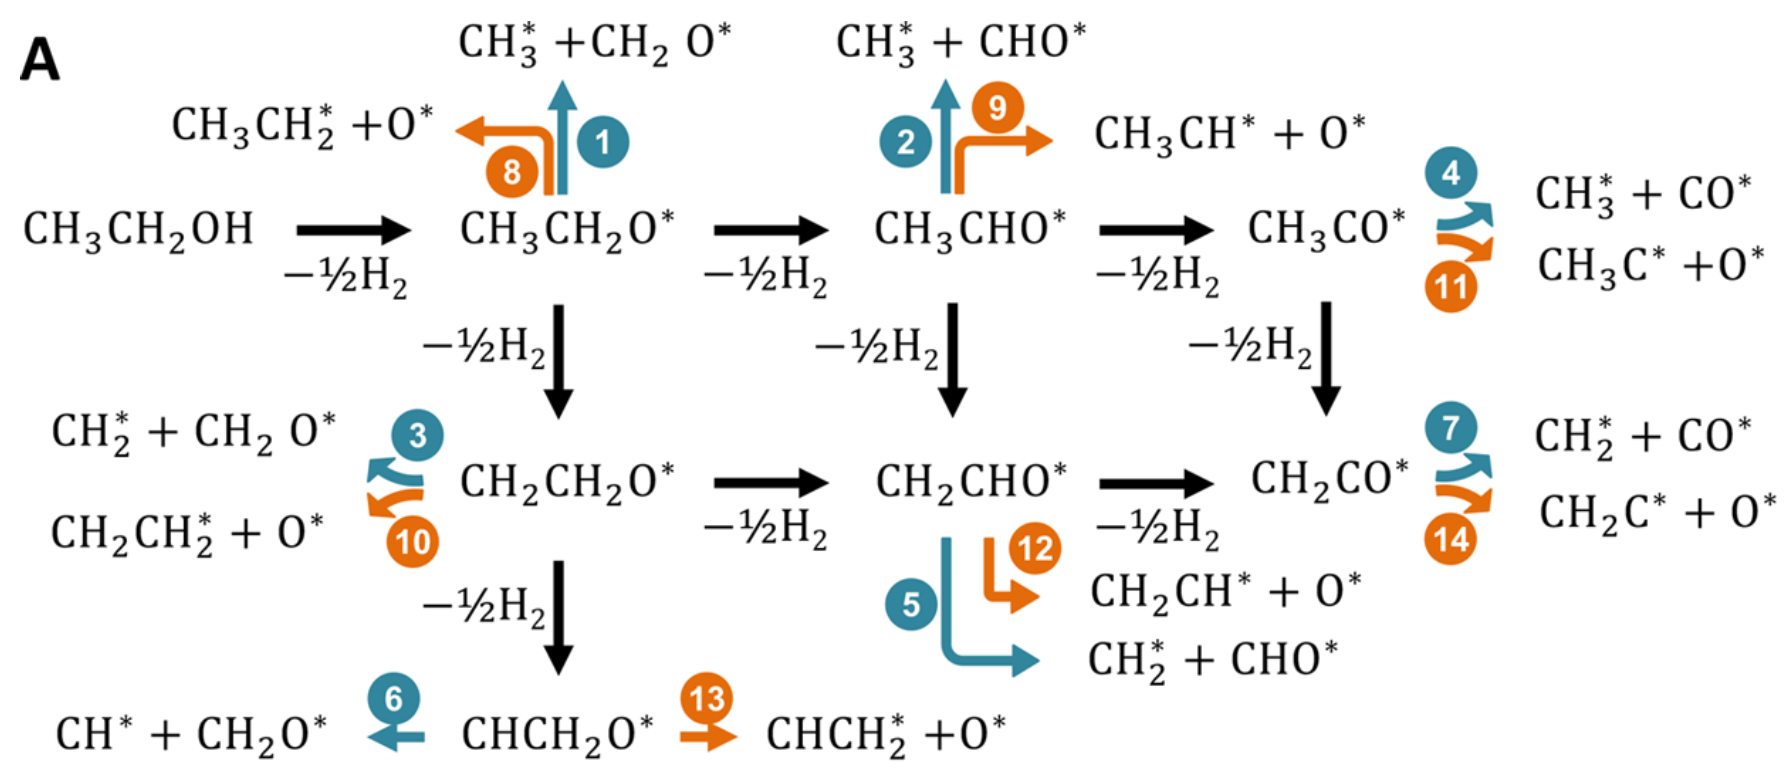

The first step is to combine the transition state and reaction energies from DFT and ML with the experimental data.

In [ ]:
df_all['Er'] = df_all['Final'] - df_all['Initial']

data = {'Surface': [], 'TS_CC_1': [], 'TS_CC_2': [], 'TS_CC_3': [],
        'TS_CC_4': [], 'TS_CC_5': [], 'TS_CC_6': [], 'TS_CC_7': [],
        'TS_CO_8': [], 'TS_CO_9': [], 'TS_CO_11': [], 'TS_CO_12': [],
        'TS_CO_14': [], 'ER_CC_1': [], 'ER_CC_2': [], 'ER_CC_3': [],
        'ER_CC_4': [], 'ER_CC_5': [], 'ER_CC_6': [], 'ER_CC_7': [],
        'ER_CO_8': [], 'ER_CO_9': [], 'ER_CO_11': [], 'ER_CO_12': [],
        'ER_CO_14': [], 'Total Activity': [], 'Reforming Activity': [],
        'Reforming': [], 'Decomposition': [], 'CH4': []}

for surface in set(df_all['Surface']):
  data['Surface'].append(surface)
  surface_data = df_all[df_all['Surface'] == surface][['Surface', 'ID', 'CO_or_CC', 'E_TS', 'Er']]
  for d in surface_data.iterrows():
    bond = 'CC' if d[1]['CO_or_CC'] == 1 else 'CO'
    name = 'TS_{}_{}'.format(bond, d[1]['ID'])
    if name in data:
      data[name].append(d[1]['E_TS'])
    name = 'ER_{}_{}'.format(bond, d[1]['ID'])
    if name in data:
      data[name].append(d[1]['Er'])
  if surface in df_exp['Surface'].values:
    idx = (df_exp['Surface'] == surface)
    data['Total Activity'].append(
        float(df_exp[idx]['Total Activity']))
    data['Reforming Activity'].append(
        float(df_exp[idx]['Total Activity'])
        * float(df_exp[idx]['Reforming']))
    data['Reforming'].append(float(df_exp[idx]['Reforming']))
    data['Decomposition'].append(float(df_exp[idx]['Decomposition']))
    data['CH4'].append(float(df_exp[idx]['CH4']))
  else:
    data['Total Activity'].append(None)
    data['Reforming Activity'].append(None)
    data['Reforming'].append(None)
    data['Decomposition'].append(None)
    data['CH4'].append(None)

data = pd.DataFrame(data)

# removing surfaces that are not based on Pt
data = data[data['Surface'] != 'Pd(111)']
data = data[data['Surface'] != 'Pd1Au2(111)']
data = data[data['Surface'] != 'Pd2Au1(111)']

data

For the model construction, it is useful to have a separate data set that only contains those surfaces for which experimental data is available.

In [ ]:
data_with_exp = data[~data['CH4'].isna()]
data_wo_exp = data[data['CH4'].isna()]

## Linear Regression Total Activity Model

The original publication identified two transition-state and two reaction energies as optimal features for a linear regression model of the total activity.  Here, we will only repeat the model construction not the feature optimization.

In [ ]:
features = ['TS_CC_6', 'TS_CO_8', 'ER_CC_4', 'ER_CC_5']

X2 = data_with_exp[features]
Y2 = data_with_exp['Total Activity'].values

activity_model = LinearRegression()
activity_model.fit(X2, Y2)
print(activity_model.coef_)

Y2_predict = activity_model.predict(X2)
print('Total Activity RMSE = {:.3f} ml'.format(mean_squared_error(Y2, Y2_predict, squared=False)))
print('Total Activity MAE  = {:.3f} ml'.format(mean_absolute_error(Y2, Y2_predict)))

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot([0, 0.2], [0, 0.2], c='black', lw=0.5)
ax.scatter(Y2, Y2_predict, marker='x')
ax.set_xlabel('Experimental Total Activity $A$ (ml)')
ax.set_ylabel('Predicted Total Activity $A$ (ml)')
ax.set_xlim((0, 0.2))
ax.set_ylim((0, 0.2))
plt.show()

Predicting the total activity for all surfaces without experimental data.

In [ ]:
A = activity_model.predict(data_wo_exp[features])
data_wo_exp['Predicted Total Activity'] = A

## Reforming Activity Model

Similarly, we construct a linear model for the reforming activity based on the three features originally reported, two transition state energies and one reaction energy.

In [ ]:
features = ['TS_CC_2', 'TS_CO_8', 'ER_CO_8']

X3 = data_with_exp[features]
Y3 = data_with_exp['Reforming Activity'].values

ref_activity_model = LinearRegression()
ref_activity_model.fit(X3, Y3)
print(ref_activity_model.coef_)

Y3_predict = ref_activity_model.predict(X3)
print('Reforming Activity RMSE = {:.3f} ml'.format(mean_squared_error(Y3, Y3_predict, squared=False)))
print('Reforming Activity MAE  = {:.3f} ml'.format(mean_absolute_error(Y3, Y3_predict)))

And the plot...

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot([0, 0.1], [0, 0.1], c='black', lw=0.5)
ax.scatter(Y3, Y3_predict, marker='x')
ax.set_xlabel('Experimental Reforming Activity $a$ (ml)')
ax.set_ylabel('Predicted Reforming Activity $a$ (ml)')
ax.set_xlim((0, 0.1))
ax.set_ylim((0, 0.1))
plt.show()

Predicting the reforming activity for all surfaces without experimental data.

In [ ]:
a = ref_activity_model.predict(data_wo_exp[features])
data_wo_exp['Predicted Reforming Activity'] = a

## Selectivity models

The reforming selectivity is the fraction of the total activity $A$ that is due to the reforming reaction, i.e., the reforming activity $a$.  Hence, the selectivity is 

$$S = \frac{a}{A} \quad.$$

In [ ]:
S_exp = data_with_exp['Reforming Activity'].values/data_with_exp['Total Activity'].values
S_model = Y3_predict/Y2_predict

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot([0, 110], [0, 110], c='black', lw=0.5)
ax.scatter(S_exp*100, S_model*100, marker='x')
ax.set_xlabel('Experimental Reforming Selectivity $S$ (%)')
ax.set_ylabel('Predicted Reforming Selectivity $S$ (%)')
ax.set_xlim((0, 110))
ax.set_ylim((0, 110))
plt.show()

And for the surfaces without experimental data.

In [ ]:
data_wo_exp['Predicted Reforming Selectivity'] = data_wo_exp['Predicted Reforming Activity']/data_wo_exp['Predicted Total Activity']

Note that one of the selectivities predicted by the model is above 100%, which obviously doesn't make sense.  We could use more sophisticated techniques to ensure that the selectivity is always between 0 and 100%, but here we keep it simple. Take a look at the original publication for one way to constrain the model predictions.

## Predicted Reforming Activity and Selectivty

Above, after constructing each mode, we also already predicted the activity and selectivity for those surfaces that we did not have any experimental data for.  Here, we inspect the results of the predictions.

Note: Google Colab allows converting the following data frame to an interactive table.

In [ ]:
data_wo_exp[['Surface', 'Predicted Reforming Activity', 'Predicted Reforming Selectivity']]

In [ ]:
a = data_wo_exp['Predicted Reforming Activity'].values
S = data_wo_exp['Predicted Reforming Selectivity'].values
n = data_wo_exp['Surface']

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(a, S*100)
for i, lbl in enumerate(n):
  ax.annotate(lbl, (a[i]+0.003, S[i]*100), fontsize=10)
ax.set_xlabel('Predicted Reforming Activity (ml)')
ax.set_ylabel('Predicted Reforming Selectivity (%)')
ax.set_xlim((0, np.max(a)+0.05))
ax.set_ylim((0, np.max(S)*100+10))
plt.show()